In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from User_Classes import UserClass
from Advertising_Environment import calculate_margin, calculate_price_index
from Clairvoyant import find_optimal_bid_for_class

In [5]:
%cd ..

c:\Users\Andrea\Documents\GitHub\OLA_2023_Private


In [6]:
from Advertising.GPTS_Learner import GPTS_Learner

import warnings
warnings.filterwarnings("ignore")

In [7]:
%cd Project-Pricing-Advertising-2022-2023

c:\Users\Andrea\Documents\GitHub\OLA_2023_Private\Project-Pricing-Advertising-2022-2023


# Environment

In [8]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200

user = UserClass(name='C1')

#names = ['Young ', 'Old', 'Not Sporty', 'Sporty']

price = 200
T = 365
n_experiments = 1000

gpts_rewards_per_experiment = []

optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))

In [9]:
def fun(user_class, bid, price):
    mean_per_bid = user_class.get_click_bids(bid) * (user_class.get_conversion_per_price(price) * calculate_margin(price)) - user_class.get_click_bids(bid) * user_class.get_cost_per_click(bid)    #sample_cost
    return mean_per_bid

In [10]:
class BiddingEnvironment:
    def __init__(self, bids, sigma, user_class, price, n_arms):
        self.bids = bids
        self.means = self.initialize_means(user_class=user_class, bids=bids, price=price)
        self.sigmas = np.ones(len(bids)) * sigma
        self.price = price
        self.n_arms = n_arms

    def initialize_means(self, user_class, bids, price):
        means = np.zeros(len(bids))
        for i in range(len(means)):
                means[i] = fun(user_class, bids[i], price)
        return means

    def round(self, pulled_arm):
        #print('Means')
        #print(self.means[pulled_arm])
        #print('Means Array')
        #print(self.means)
        return np.random.normal(self.means[pulled_arm], self.sigmas[pulled_arm])

# Experiment

In [11]:
for e in tqdm(range(0, 2)):
    env = BiddingEnvironment(bids=bids, sigma = sigma, user_class=user, price=price, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)

    for t in tqdm(range(T)):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)

100%|██████████| 2/2 [13:50<00:00, 415.43s/it]


In [12]:
gpts_rewards_per_experiment[1]

array([13778.32432816, 13662.4480137 ,  6688.45534774, 13802.98607798,
       13512.44887659, 14227.80787243, 12530.62123045, 10586.29268598,
       13890.06198933, 13939.88277882, 13884.62789628, 13824.96121918,
       13944.66119025, 13601.67897942, 13995.81519066, 14123.68167212,
       13688.9299069 , 14111.44380148, 13480.12348178, 13722.81584681,
       13738.66358878, 13529.39107298, 13779.83112217, 13509.95861359,
       13820.88586174, 12280.19484785, 11191.25108484, 14072.53764627,
        6750.19838164, 13797.47377716, 13885.96725216, 13572.80707745,
       13570.99326627, 13949.37164166, 13400.91119719, 13765.22059942,
       13572.49634399, 13733.43645789, 13529.95352376, 13150.59708558,
       11403.05891501, 13114.49618687, 11205.69868245, 13415.48551959,
       13661.94056792,  4033.56012127, 13865.5930321 , 13595.84005674,
       13507.03431018, 13306.41834221, 14373.09357889, 13637.36486837,
       13655.47004601, 13707.3857866 , 13736.76590762, 13754.41933348,
      

In [13]:
optimum_bid

(1.0, 13767.97338369385)

# Plot

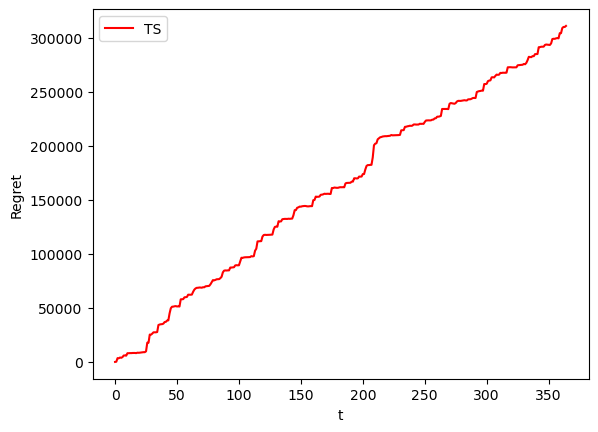

In [14]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r')
plt.legend(["TS", "UCB"])
plt.show()